In [ ]:
## evaluation of AU ROC, PR ROC, F1 scores to determine the optimal threshold

In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [3]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [4]:
perfdata = defaultdict(lambda: defaultdict(list))

factor_labels = list()

FileNotFoundError: File b'..\\grouped-mean-bestepoch-bydrug-CB_8-AR-125_222_24_10_1e-06_256_32.csv' does not exist

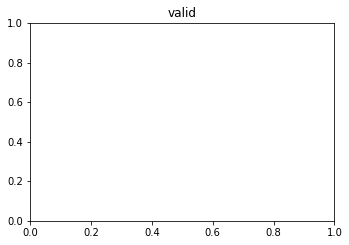

In [5]:
for modeltype in ('bestepoch'):
    resfiles = [
        "grouped-mean-bestepoch-bydrug-CB_8-AR-125_222_24_10_1e-06_256_32.csv"
    ]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)
            
            if modeltype == 'final' and split == 'valid':
                factor_labels.append(experiment['labels'][i])
            
            # Special processing for the ALL sections file
            sections = []
            if 'ALL' in resfile:
                sections = ('AR', 'BW', 'WP')
                groupname = 'ALL'
            elif 'ARBW' in resfile:
                sections = ('AR', 'BW')
                groupname = 'ARBW'
            
            if len(sections) > 0:
                for section in sections:
                    section_df = split_df[split_df['section'] == section]
                    section_prdata = ph.prdata(section_df['label'], section_df['Pred1'])
                    perfdata[(modeltype, split)]['prdata'].append(section_prdata)
                    if modeltype == 'final' and split == 'valid':
                        factor_labels.append(f'{section}-{groupname}')


        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)
            
            # Special processing for the ALL sections file
            sections = []
            if 'ALL' in resfile:
                sections = ('AR', 'BW', 'WP')
                groupname = 'ALL'
            elif 'ARBW' in resfile:
                sections = ('AR', 'BW')
                groupname = 'ARBW'
            
            if len(sections) > 0:
                for section in sections:
                    section_df = split_df[split_df['section'] == section]
                    section_rocdata = ph.rocdata(section_df['label'], section_df['Pred1'], prdata['max_f1_threshold'])
                    perfdata[(modeltype, split)]['rocdata'].append(section_rocdata)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

valid max f1 threshold: 2.553029060363769
test max f1 threshold: 2.54717718064785


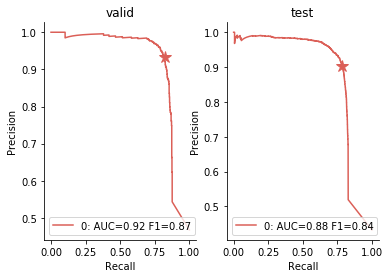

In [31]:
plotcounter = 1

# precision recall curves

for split in ('valid', 'test'):
    plt.subplot(1, 2, plotcounter)
    plotcounter += 1
    plt.title(split)
    
    df = pd.read_csv("./results/grouped-mean-bestepoch-bydrug-CB_8-AR-125_222_24_10_1e-06_256_32.csv", index_col=0)
    
    
    df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
    
    split_df = df[df['split']==split]

    prdata = ph.prdata(split_df['label'], split_df['Pred1'])
    perfdata[(modeltype, split)]['prdata'].append(prdata)
    
    plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
             label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
            )
    plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)
    
    if modeltype == 'final' and split == 'valid':
        factor_labels.append(experiment['labels'][i])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    sns.despine()
    
    print(split, f"max f1 threshold:", prdata["max_f1_threshold"])



valid 2.553029060363769
test 2.54717718064785


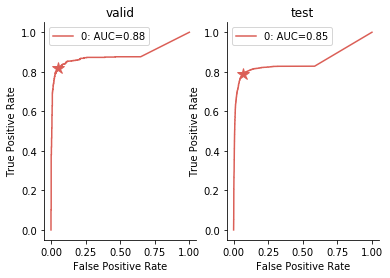

In [29]:
plotcounter = 1

# AUC ROC curves
for split in ('valid', 'test'):
    plt.subplot(1, 2, plotcounter)
    plotcounter += 1
    plt.title(split)

    df = pd.read_csv("./results/grouped-mean-bestepoch-bydrug-CB_8-AR-125_222_24_10_1e-06_256_32.csv", index_col=0)

    df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
    split_df = df[df['split']==split]

    prdata = ph.prdata(split_df['label'], split_df['Pred1'])
    rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
    perfdata[(modeltype, split)]['rocdata'].append(rocdata)
    
    plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
             label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
            )
    plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    sns.despine()
    
    print(split, prdata["max_f1_threshold"])

In [25]:
prdata

{'precision': array([0.43256043, 0.51886253, 0.51893669, ..., 1.        , 1.        ,
        1.        ]),
 'recall': array([1.00000000e+00, 8.28239051e-01, 8.28239051e-01, ...,
        4.56204380e-04, 2.28102190e-04, 0.00000000e+00]),
 'max_f1': 0.8409118615140803,
 'max_f1_threshold': 2.54717718064785,
 'max_f1_precision': 0.9031159989526054,
 'max_f1_recall': 0.7867244525547445,
 'pr_auc': 0.8841328516713092}